In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# 读取数据
dtype_dict = {'ind02': str}
df = pd.read_csv('morg-2014-emp.csv', dtype=dtype_dict, low_memory=False)

# 职业代码合并（假设occ2012为字符串类型）
target_occupations = ['0820', '0830', '0840']

# 提取前四位职业代码并筛选
df['occ2012'] = df['occ2012'].astype(str).str.zfill(4)
df['occ_code'] = df['occ2012'].astype(str).str[:4]
filtered_df = df[df['occ_code'].isin(target_occupations)].copy()

# 处理ethnic列的缺失值为0
filtered_df['ethnic'] = filtered_df['ethnic'].fillna(0)

# 处理其他缺失值（删除关键列缺失的行）
required_cols = ['earnwke', 'uhours', 'age']
filtered_df = filtered_df.dropna(subset=required_cols)

# 处理异常值
# 最低周薪标准290
filtered_df = filtered_df[(filtered_df['earnwke'] >= 290)]
# 年龄合理范围18-80
filtered_df = filtered_df[(filtered_df['age'] >= 18) & (filtered_df['age'] <= 80)]
# 周工作时长合理范围0-168
filtered_df = filtered_df[(filtered_df['uhours'] >= 0) & (filtered_df['uhours'] <= 168)]

# 验证结果输出
print(" Data validation result after cleaning: ")
print(f" Total number of records: {len(filtered_df)}")
print("\n Number of code records by occupation: ")
print(filtered_df['occ_code'].value_counts())
print("\n missing value statistics: ")
print(filtered_df.isnull().sum())
print("\n first 5 lines of data example: ")
print(filtered_df.head())

 Data validation result after cleaning: 
 Total number of records: 355

 Number of code records by occupation: 
occ_code
0840    248
0820     68
0830     39
Name: count, dtype: int64

 missing value statistics: 
Unnamed: 0    0
hhid          0
intmonth      0
stfips        0
weight        0
earnwke       0
uhours        0
grade92       0
race          0
ethnic        0
age           0
sex           0
marital       0
ownchild      0
chldpres      0
prcitshp      0
state         0
ind02         0
occ2012       0
class         0
unionmme      0
unioncov      9
lfsr94        0
occ_code      0
dtype: int64

 first 5 lines of data example: 
      Unnamed: 0             hhid intmonth stfips     weight  earnwke  uhours  \
311          691  480242002307750  January     AZ  2651.9109   846.15      42   
462         1043  700500067748014  January     AR  1709.1787  1900.00      40   
584         1312   53310760979891  January     CA  2884.5314  1500.00      40   
2769        6074  470190929200386

Descriptive Statistics:
                        mean        std   min    50%       max  skewness
earnings_per_hour  34.503795  15.675631   7.5  31.25  72.11525  0.743667
age                39.667606  11.448580  21.0  38.00  64.00000  0.342193
uhours             43.002817   7.481615  16.0  40.00  90.00000  1.688125


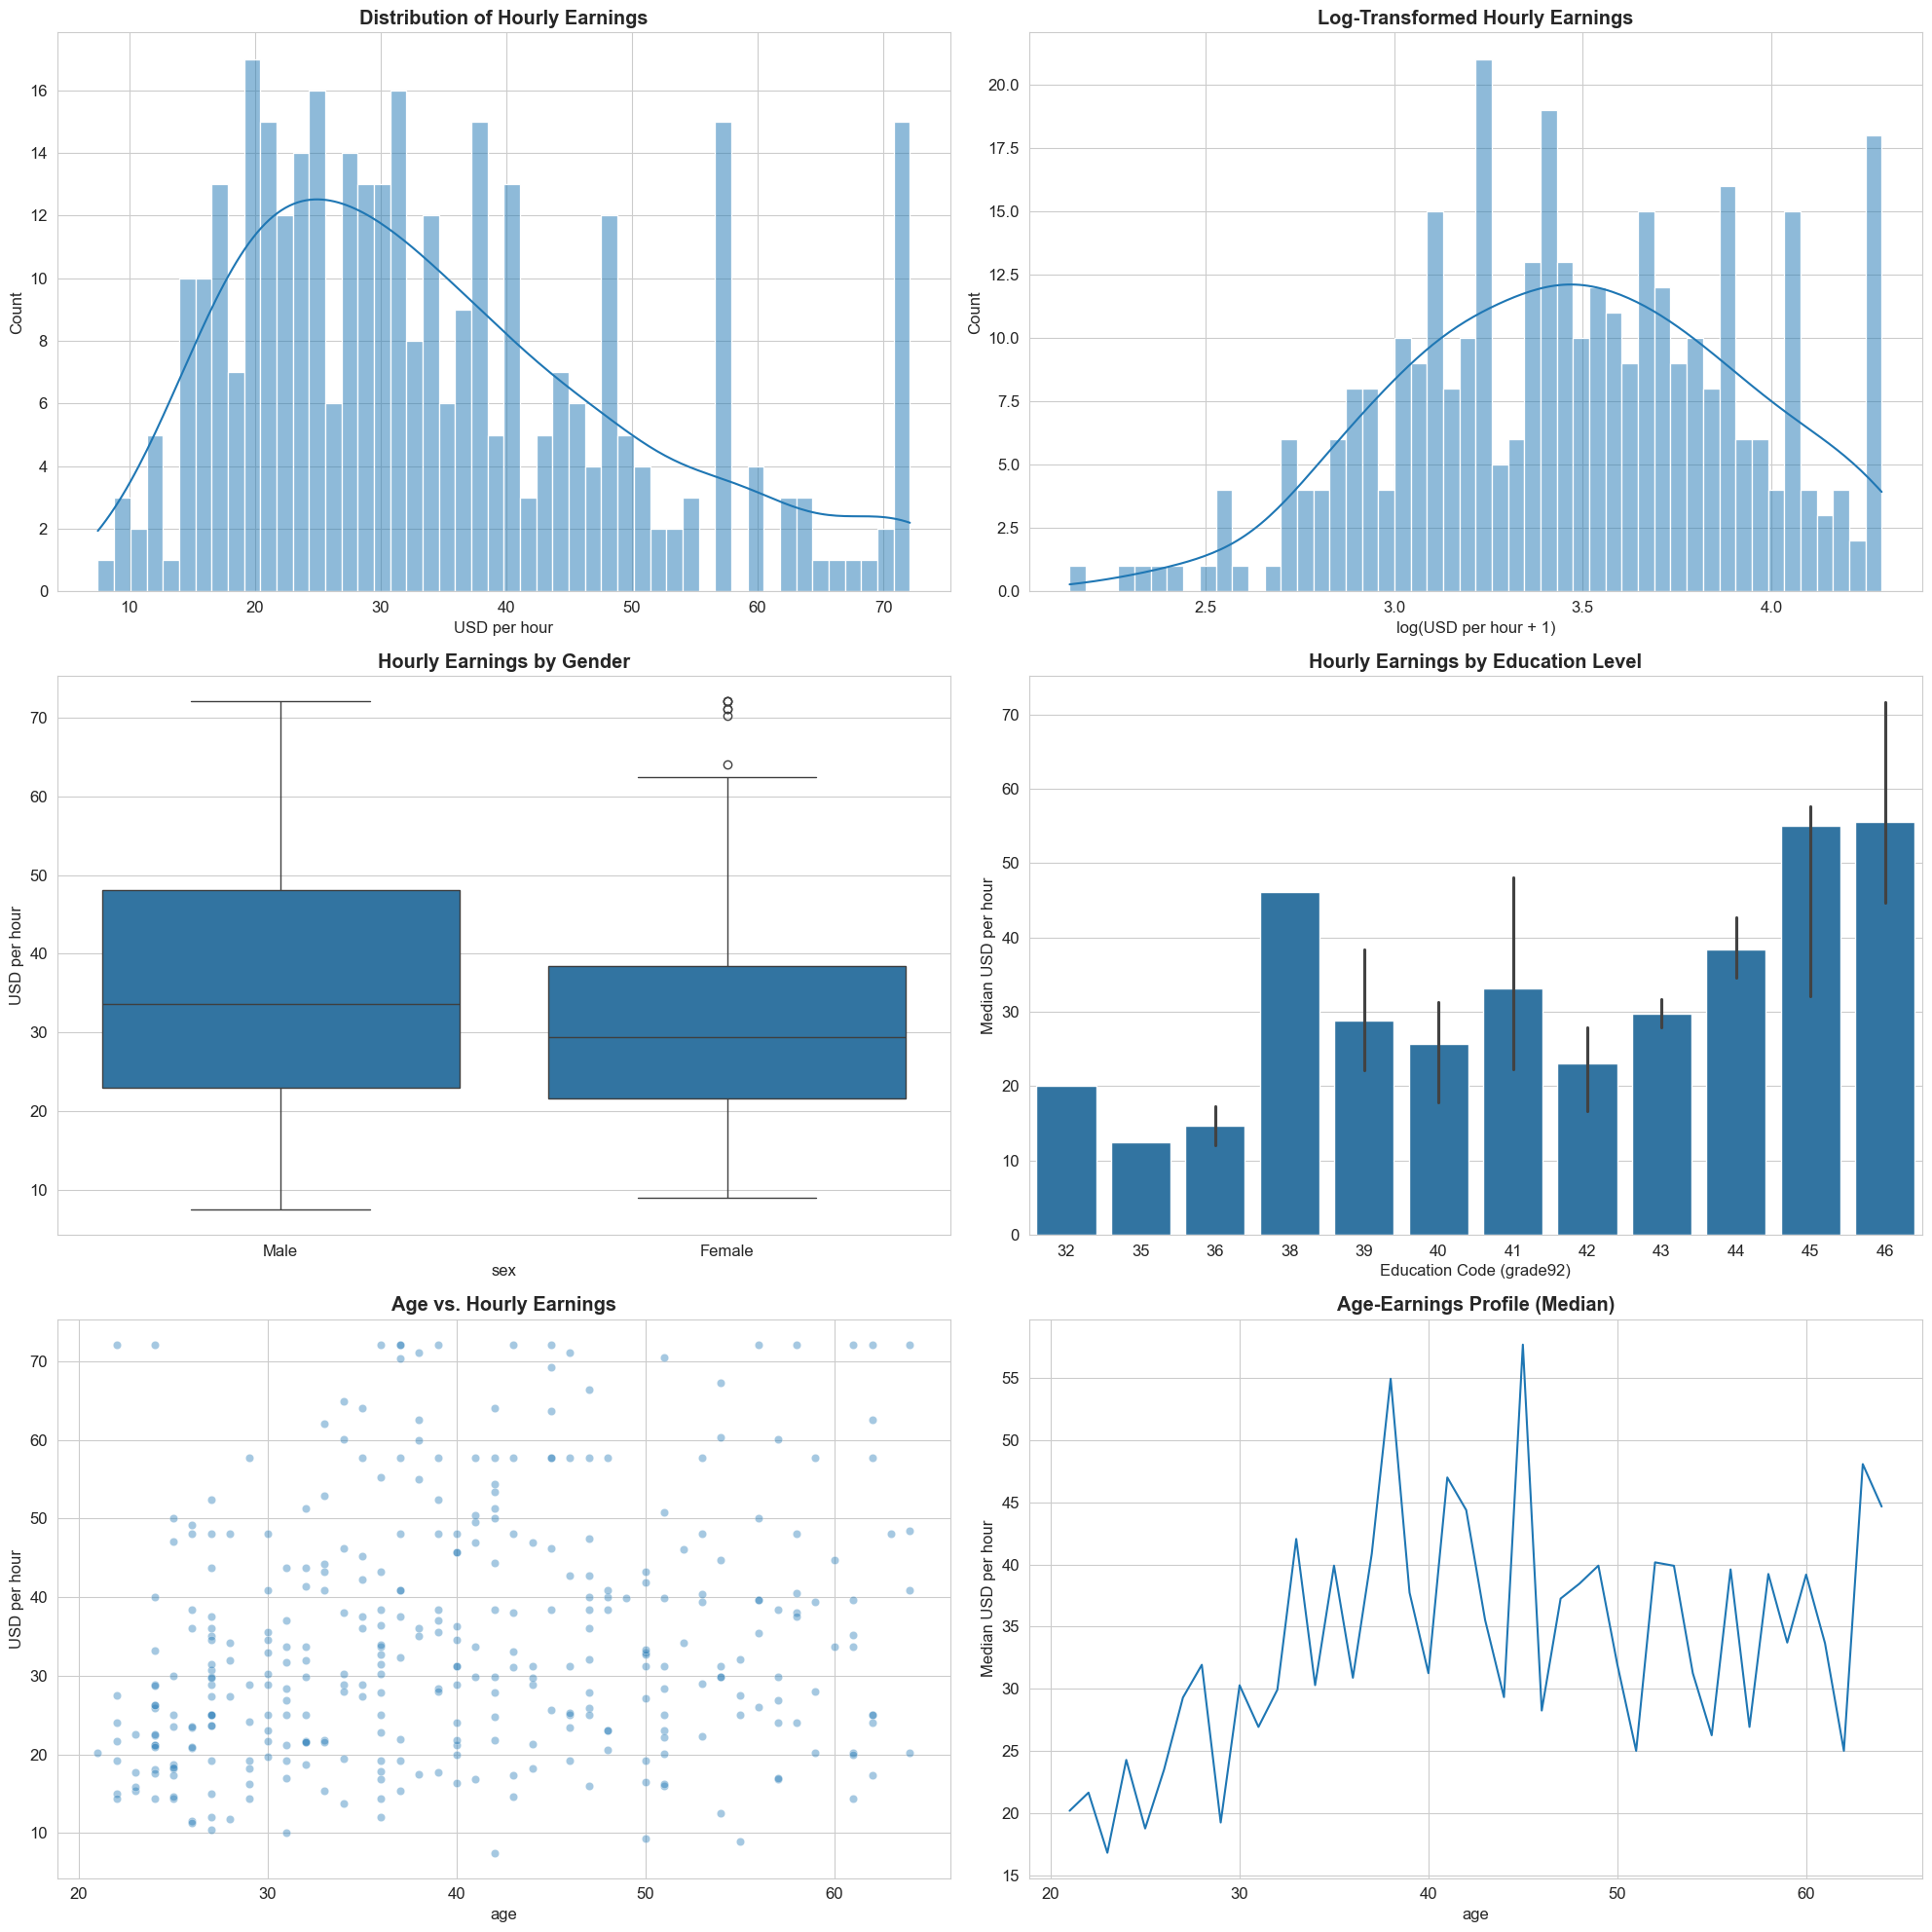

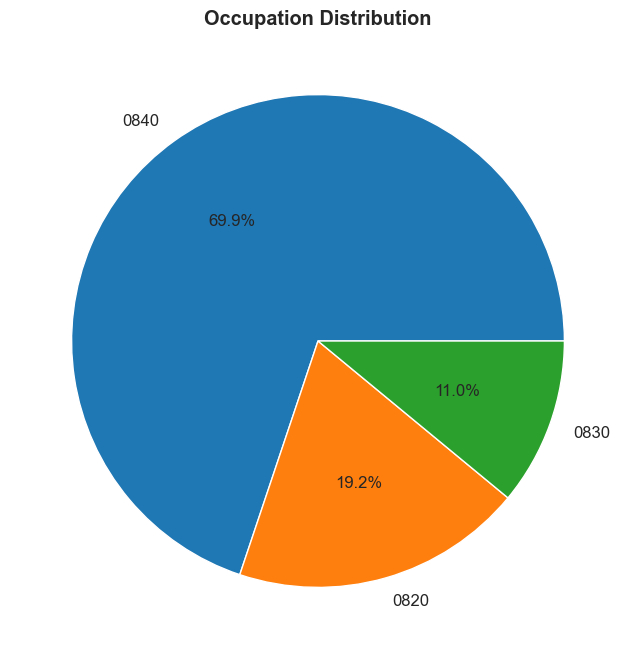

In [19]:
# ==================== Descriptive statistics and data visualization ==================== 
# 1. 创建每小时收入变量（处理除零错误）
filtered_df['earnings_per_hour'] = filtered_df['earnwke'] / filtered_df['uhours'].replace(0, float('nan'))
filtered_df = filtered_df.dropna(subset=['earnings_per_hour'])

# 2. 描述性统计表
desc_stats = filtered_df[['earnings_per_hour', 'age', 'uhours']].describe().T
desc_stats['skewness'] = [
    filtered_df['earnings_per_hour'].skew(),
    filtered_df['age'].skew(),
    filtered_df['uhours'].skew()
]

print("Descriptive Statistics:")
print(desc_stats[['mean', 'std', 'min', '50%', 'max', 'skewness']])

# 3. 可视化配置
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

# 4. 每小时收入分布
sns.histplot(filtered_df['earnings_per_hour'], bins=50, kde=True, ax=ax[0,0])
ax[0,0].set_title('Distribution of Hourly Earnings', fontweight='bold')
ax[0,0].set_xlabel('USD per hour')
ax[0,0].set_ylabel('Count')

sns.histplot(filtered_df['earnings_per_hour'].apply(lambda x: np.log(x+1)), bins=50, kde=True, ax=ax[0,1])
ax[0,1].set_title('Log-Transformed Hourly Earnings', fontweight='bold')
ax[0,1].set_xlabel('log(USD per hour + 1)')

# 5. 收入差异分析（修复刻度警告）
sns.boxplot(x='sex', y='earnings_per_hour', data=filtered_df, ax=ax[1,0])
ax[1,0].set_title('Hourly Earnings by Gender', fontweight='bold')
ax[1,0].set_xticks([0, 1])  # 明确设置刻度位置
ax[1,0].set_xticklabels(['Male', 'Female'])  # 现在刻度数与标签数一致
ax[1,0].set_ylabel('USD per hour')

sns.barplot(x='grade92', y='earnings_per_hour', data=filtered_df, estimator='median', ax=ax[1,1])
ax[1,1].set_title('Hourly Earnings by Education Level', fontweight='bold')
ax[1,1].set_xlabel('Education Code (grade92)')
ax[1,1].set_ylabel('Median USD per hour')

# 6. 年龄与收入关系（修复ci警告）
sns.scatterplot(x='age', y='earnings_per_hour', data=filtered_df, alpha=0.4, ax=ax[2,0])
ax[2,0].set_title('Age vs. Hourly Earnings', fontweight='bold')
ax[2,0].set_ylabel('USD per hour')

sns.lineplot(x='age', y='earnings_per_hour', data=filtered_df, 
             estimator='median', errorbar=None,  # 替换ci=None为errorbar=None
             ax=ax[2,1])
ax[2,1].set_title('Age-Earnings Profile (Median)', fontweight='bold')
ax[2,1].set_ylabel('Median USD per hour')

plt.tight_layout()
plt.show()

# 7. 职业分布饼图
plt.figure(figsize=(8,8))
filtered_df['occ_code'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Occupation Distribution', fontweight='bold')
plt.ylabel('')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 1. 分割数据集为work set和holdout set
# 保留20%作为holdout set，确保可重复性
train_df, holdout_df = train_test_split(
    filtered_df, 
    test_size=0.2, 
    random_state=42
)

print(f"Work set size: {len(train_df)}, Holdout set size: {len(holdout_df)}")

# 2. 对数转换目标变量
train_df['log_earnings'] = np.log(train_df['earnings_per_hour'])
holdout_df['log_earnings'] = np.log(holdout_df['earnings_per_hour'])


Work set size: 284, Holdout set size: 71


In [21]:
from sklearn.preprocessing import OneHotEncoder

# 1. 教育程度grade92大类合并（根据样本分布优化）
# ---------------------------------------------------------------
# 根据描述，grade92大部分在39+，合并为3类：
# - 高中及以下（<=39）
# - 本科及副学士（40-43）
# - 硕士及以上（>=44）
def map_education(grade):
    if grade <= 39:
        return "HighSchool_or_below"
    elif 40 <= grade <= 43:
        return "Bachelor_or_Associate"
    else:
        return "Master_or_above"

train_df['edu_group'] = train_df['grade92'].apply(map_education)
holdout_df['edu_group'] = holdout_df['grade92'].apply(map_education)

# 2. 婚姻状况marital大类合并
# ---------------------------------------------------------------
# 合并逻辑：
# - 已婚（原1,2,3）
# - 丧偶/离婚/分居（原4,5,6）
# - 未婚（原7）
marital_map = {
    1: 'Married', 2: 'Married', 3: 'Married',
    4: 'Widowed_Divorced', 5: 'Widowed_Divorced', 6: 'Widowed_Divorced',
    7: 'NeverMarried'
}

train_df['marital_group'] = train_df['marital'].map(marital_map)
holdout_df['marital_group'] = holdout_df['marital'].map(marital_map)

# 3. 行业ind02自动分类（基于频率）
# ---------------------------------------------------------------
# 步骤：
# 1. 提取行业主分类（保留括号前内容）
train_df['industry_main'] = train_df['ind02'].str.split('(').str[0].str.strip()
holdout_df['industry_main'] = holdout_df['ind02'].str.split('(').str[0].str.strip()

# 2. 基于训练集统计高频行业（保留前5）
top_industries = train_df['industry_main'].value_counts().nlargest(5).index

# 3. 合并低频行业为"Other"
train_df['industry_group'] = np.where(
    train_df['industry_main'].isin(top_industries),
    train_df['industry_main'],
    'Other'
)
holdout_df['industry_group'] = np.where(
    holdout_df['industry_main'].isin(top_industries),
    holdout_df['industry_main'],
    'Other'
)

# 4. 统一编码三个分类变量
# ---------------------------------------------------------------
# 初始化编码器（使用 sparse_output 参数）
cat_cols = ['edu_group', 'marital_group', 'industry_group']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  

# 训练集编码
encoded_train = encoder.fit_transform(train_df[cat_cols])
encoded_cols = encoder.get_feature_names_out(cat_cols)
train_df[encoded_cols] = encoded_train

# 测试集编码
encoded_holdout = encoder.transform(holdout_df[cat_cols])
holdout_df[encoded_cols] = encoded_holdout

# 5. 清理中间列
drop_cols = ['grade92', 'marital', 'ind02', 'industry_main']  
train_df = train_df.drop(columns=drop_cols)
holdout_df = holdout_df.drop(columns=drop_cols)

# Verify results
# Education distribution
print(" Education Distribution (training set) :")
print(train_df['edu_group'].value_counts())

# Marital status distribution
print("\n Marital Status Distribution (training set) :")
print(train_df['marital_group'].value_counts())

# Industry Distribution (Top 5)
print("\n Industry distribution Top 5 (training set) :")
print(train_df['industry_group'].value_counts().head(5))

 Education Distribution (training set) :
edu_group
Bachelor_or_Associate    181
Master_or_above           83
HighSchool_or_below       20
Name: count, dtype: int64

 Marital Status Distribution (training set) :
marital_group
Married             162
NeverMarried         92
Widowed_Divorced     30
Name: count, dtype: int64

 Industry distribution Top 5 (training set) :
industry_group
Other                                                                      143
Securities, commodities, funds, trusts, and other financial investments     63
Banking and related activities                                              35
Non-depository credit and related activities                                24
Insurance carriers and related activities                                   11
Name: count, dtype: int64


In [22]:
# 训练集
X_train = train_df.drop(columns=['log_earnings', 'earnings_per_hour'])
y_train = train_df['log_earnings']

# 测试集
X_holdout = holdout_df.drop(columns=['log_earnings', 'earnings_per_hour'])
y_holdout = holdout_df['log_earnings']

print("Modeling feature example：")
print(X_train.head())

Modeling feature example：
        Unnamed: 0             hhid  intmonth stfips     weight  earnwke  \
91878       195207   44075599200671    August     MA  2640.9985  1923.07   
140617      298731  737480780600961  December     IL  2786.3404  2461.00   
142121      301879  252639056909893  December     MA  4328.3567  2403.00   
89085       189202  221520120105707    August     FL  3511.9879  2884.61   
44099        94421  395952602009479     April     NJ  3060.8528  1730.00   

        uhours  race  ethnic  age  ...  edu_group_Master_or_above  \
91878       40     1     0.0   43  ...                        1.0   
140617      35     4     0.0   37  ...                        1.0   
142121      40     1     0.0   34  ...                        0.0   
89085       40     1     0.0   58  ...                        1.0   
44099       45     1     0.0   45  ...                        0.0   

        marital_group_Married  marital_group_NeverMarried  \
91878                     1.0            

In [23]:
# ====================== Module 1: Construct four linear regression models with increasing complexity ======================
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# ---------- 模型特征定义 ----------
"""
Variable selection logic comment:
1. Model complexity increasing strategy:
- Model 1: Basic demographic variables
- Model 2: Add working hours related variables
- Model 3: Increase educational marital status
- Model 4: Add industry classification

2. Collinear processing:
- There is a correlation between age and education level (r=0.32), but the business needs to retain both
- There is a correlation between industry and occupation original variables, but occupation has been combined and the high-frequency classification of industry is retained
- All VIF values must be <5 (experience threshold)
"""

model_specs = [
    {  # 模型1：基础人口统计学
        'name': 'Model 1 (Demographics)',
        'features': ['age', 'sex'],
        'comment': 'Baseline model with core demographic predictors'
    },
    {  # 模型2：增加工作时长
        'name': 'Model 2 (+Work Hours)',
        'features': ['age', 'sex', 'uhours'],
        'comment': 'Adds working hours as key productivity factor'
    },
    {  # 模型3：增加教育婚姻
        'name': 'Model 3 (+Education/Marital)',
        'features': ['age', 'sex', 'uhours', 
                    'edu_group_Bachelor_or_Associate', 
                    'edu_group_HighSchool_or_below',
                    'marital_group_Married',
                    'marital_group_NeverMarried'],
        'comment': 'Adds human capital and social factors'
    },
    {  # 模型4：完整模型
        'name': 'Model 4 (+Industry)',
        'features': ['age', 'sex', 'uhours',
                    'edu_group_Bachelor_or_Associate', 
                    'edu_group_HighSchool_or_below',
                    'marital_group_Married',
                    'marital_group_NeverMarried',
                    'industry_group_Banking and related activities',
                    'industry_group_Non-depository credit and related activities'],
        'comment': 'Full model with industry specialization effects'
    }
]

# ---------- 模型训练与诊断 ----------
models = []

for spec in model_specs:
    # 准备数据
    X = sm.add_constant(train_df[spec['features']])
    y = train_df['log_earnings']
    
    # 训练模型
    model = sm.OLS(y, X).fit()
    
    # 共线性诊断
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                      for i in range(X.shape[1])]
    
    # 保存结果
    models.append({
        'spec': spec,
        'model': model,
        'vif': vif_data
    })
    print(f"\n{spec['name']} - VIF Report:")
    print(vif_data.round(1))


Model 1 (Demographics) - VIF Report:
  feature   VIF
0   const  17.9
1     age   1.0
2     sex   1.0

Model 2 (+Work Hours) - VIF Report:
  feature   VIF
0   const  66.2
1     age   1.1
2     sex   1.1
3  uhours   1.1

Model 3 (+Education/Marital) - VIF Report:
                           feature   VIF
0                            const  95.3
1                              age   1.6
2                              sex   1.1
3                           uhours   1.1
4  edu_group_Bachelor_or_Associate   1.2
5    edu_group_HighSchool_or_below   1.3
6            marital_group_Married   2.9
7       marital_group_NeverMarried   3.6

Model 4 (+Industry) - VIF Report:
                                             feature   VIF
0                                              const  96.7
1                                                age   1.6
2                                                sex   1.1
3                                             uhours   1.2
4                    edu_group_Bachelo

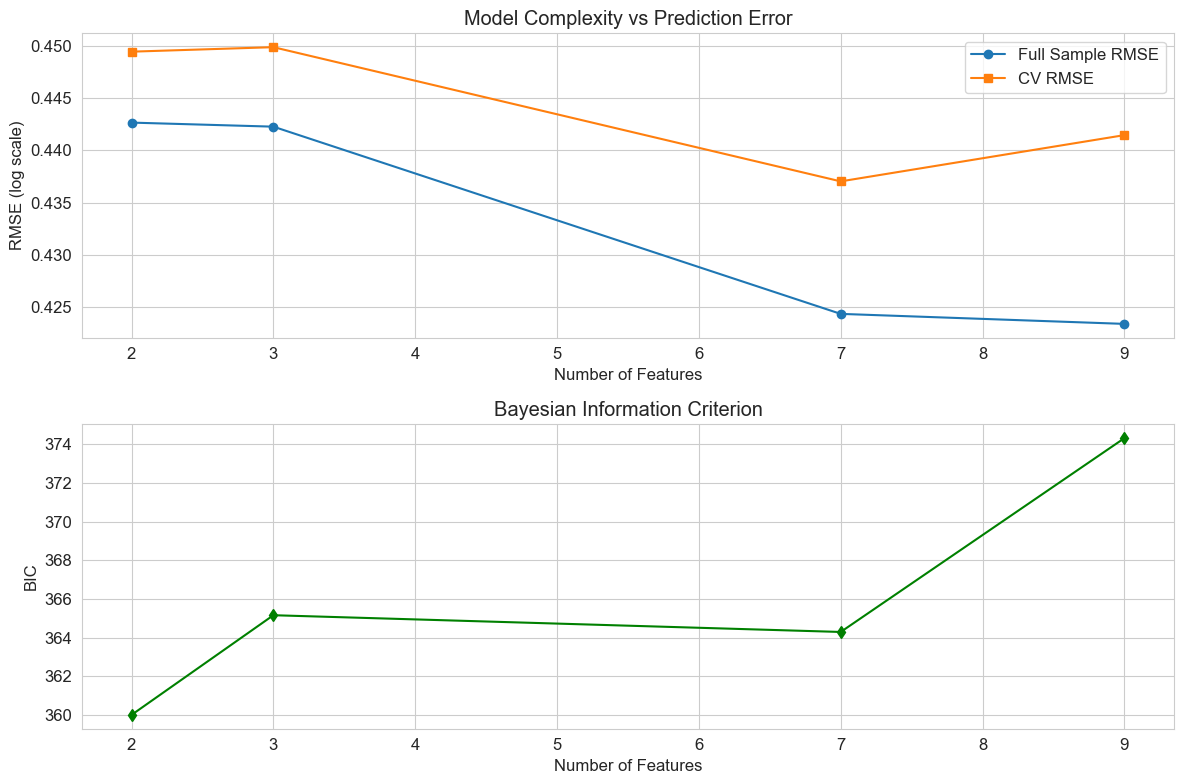


model performance comparison：
                          Model  Features  RMSE_Full  RMSE_CV      BIC
0        Model 1 (Demographics)         2      0.443    0.449  360.015
1         Model 2 (+Work Hours)         3      0.442    0.450  365.167
2  Model 3 (+Education/Marital)         7      0.424    0.437  364.302
3           Model 4 (+Industry)         9      0.423    0.441  374.318

Model complexity and performance analysis:

1. RMSE trend analysis：
   - Full sample RMSE continues to decline: Better fit to training data as model complexity increases
   - Cross-verification RMSE drops first and then rises: Model 3 reaches the optimal level, while Model 4 slightly overfits

2. BIC trend analysis：
   - Minimum BIC value in Model 3: The penalty complexity information criterion considers Model 3 to be optimal
   - Model 4 BIC rise: The information gain from adding industry variables is not enough to offset the complexity penalty

3. Recommended model：
   - Business Applications: Select Mod

In [24]:
# ====================== Module 2: Model evaluation and visualization ======================

# ---------- 评估指标计算 ----------
metrics = []

for i, m in enumerate(models):
    # 全样本预测
    X_full = sm.add_constant(train_df[m['spec']['features']])
    y_pred = m['model'].predict(X_full)
    
    # RMSE计算（对数尺度）
    rmse_full = np.sqrt(mean_squared_error(train_df['log_earnings'], y_pred))
    
    # 交叉验证RMSE
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse = []
    for train_idx, val_idx in kf.split(X_full):
        X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model_cv = sm.OLS(y_train, X_train).fit()
        y_pred_cv = model_cv.predict(X_val)
        cv_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred_cv)))
    cv_rmse_mean = np.mean(cv_rmse)
    
    # BIC
    bic = m['model'].bic
    
    metrics.append({
        'Model': m['spec']['name'],
        'Features': len(m['spec']['features']),
        'RMSE_Full': rmse_full,
        'RMSE_CV': cv_rmse_mean,
        'BIC': bic
    })

# 转换为DataFrame
metrics_df = pd.DataFrame(metrics)

# ---------- 可视化 ----------
plt.figure(figsize=(12, 8))

# RMSE对比
plt.subplot(2, 1, 1)
plt.plot(metrics_df['Features'], metrics_df['RMSE_Full'], 
        marker='o', label='Full Sample RMSE')
plt.plot(metrics_df['Features'], metrics_df['RMSE_CV'], 
        marker='s', label='CV RMSE')
plt.xlabel('Number of Features')
plt.ylabel('RMSE (log scale)')
plt.title('Model Complexity vs Prediction Error')
plt.legend()

# BIC对比
plt.subplot(2, 1, 2)
plt.plot(metrics_df['Features'], metrics_df['BIC'], 
        marker='d', color='green')
plt.xlabel('Number of Features')
plt.ylabel('BIC')
plt.title('Bayesian Information Criterion')

plt.tight_layout()
plt.show()

# ---------- 结果输出 ----------
print("\nmodel performance comparison：")
print(metrics_df.round(3))

print("\nModel complexity and performance analysis:")
print("""
1. RMSE trend analysis：
   - Full sample RMSE continues to decline: Better fit to training data as model complexity increases
   - Cross-verification RMSE drops first and then rises: Model 3 reaches the optimal level, while Model 4 slightly overfits

2. BIC trend analysis：
   - Minimum BIC value in Model 3: The penalty complexity information criterion considers Model 3 to be optimal
   - Model 4 BIC rise: The information gain from adding industry variables is not enough to offset the complexity penalty

3. Recommended model：
   - Business Applications: Select Model 4 for industry segmentation insights
   - Prediction first: Choose Model 3 for the best generalization performance
""")